### Задача

Используя модель для детекции из библиотеки `mmdetection`, оценить `accuracy` на имеющихся данных.

### Проверка окружения

Проверим какая версия `python` используется в ядре.

In [1]:
import sys
!{sys.executable} -V

Python 3.8.10


Проверим доступна ли `gpu`, верно ли встали драйвера.

In [2]:
import torch
torch.cuda.is_available(), torch.__version__

(True, '1.10.2+cu102')

### Структура выхода модели

На выходе из модели мы получаем список с numpy массивом, количество массивов равно количеству классов, и порядковый номер массива равен порядковому номеру класса. В нашем датасете 3 класса и их порядок таков: `window`, `empty`, `filled`. Значит первый массив отвечает за класс `windows`, второй за `empty` и третий за `filled`.

`[np.array(window), ..., np.array(filled)]`

В каждом массиве находятся все обнарушенные детекции и уверенность класса, которые отражает пять чисел, первые 4 координаты бокса и последнее пятое число увереность модели, что детекция принадлежит к определенному классу.

`[np.array([12, 9, 7, 9, 0.67], ..., [12, 9, 7, 9, 0.67]), ..., np.array([12, 9, 7, 9, 0.67], ..., [12, 9, 7, 9, 0.67])]`

### Создать датасет

Необходимо создать датасет (из размеченных данных) из которого мы сможем извлекать по одномму изображению.

In [90]:
data_path = '../data/for_metric'

In [263]:
import glob
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset

from torchvision.transforms import functional as F


class ReportDetectionDataset(Dataset):
    
    def __init__(self, data_path: str, device: str):
        """
        :param path: path to annotated data.
        """
        
        if data_path[-1] != '/':
            data_path += '/'
        
        self.anns_path = glob.glob(data_path + '**/*.json')[0]
        self.images_path = str(list(Path(data_path).rglob('*.jpg'))[0].parent) + '/'
        self.coco = COCO(self.anns_path)
        self.n = len(self.coco.imgs)
        self.device = device
        # соберем словарь id и названия категорий
        dicts_cats = self.coco.loadCats(self.coco.getCatIds())
        self.id_name_cats = {dict_cat['id']:dict_cat['name'] for dict_cat in dicts_cats}
    
    def image2tensor(self, image: Image.Image, device: str) -> torch.Tensor:
        """
        Checks if image is valid and moves it to the GPU.
        
        :param image: PIL.Image
        :param device: device to run op on
        :return: torch.tensor shape [bs, c, h, w]
        """
        
        if isinstance(image, Image.Image):
            image = np.array(image)
            
        if len(image.shape) != 3 or image.shape[2] != 3:
            raise Exception(
                "'predict' method takes a 3D image as input \
                of shape (H, W, 3). Instead got {}".format(
                    image.shape
                )
            )
            
        return F.to_tensor(image).unsqueeze(0).to(self.device)
    
    def conversion_bbox(self, coco_bbox: list) -> list:
        """
        Convert bbox from coco dataset format to the desired format.
        :from: `[x_topleft, y_topleft, width, height]`
        :to: `[x_topleft, y_topleft, x_bottomright, y_bottomright]`
        """
        x_topleft, y_topleft = coco_bbox[:2]
        w, h = coco_bbox[2], coco_bbox[3]
        x_bottomright = x_topleft + w
        y_bottomright = y_topleft + h
        return [x_topleft, y_topleft, x_bottomright, y_bottomright]
    
    def get_anns(self, dicts_anns: dict) -> dict:
        boxes, brands = [], []
        for dict_ann in dicts_anns:
            
            coco_bbox = dict_ann['bbox']
            bbox = self.conversion_bbox(coco_bbox)
            
            id_brand = dict_ann['category_id']
            brand = self.id_name_cats[id_brand]

            boxes.append(bbox)
            brands.append(brand)

        return {'boxes': np.array(boxes),
                'brands': brands}
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        # т.к. в coco индексирование начинается с 1, то нужно добавить 1 к индексу
        index += 1
        # получить изображение по индексу
        path2img = self.images_path + self.coco.loadImgs(index)[0]['file_name']
        image = Image.open(path2img)
        ann_img = self.coco.loadImgs(index)
        #print(np.array(image).shape)
        #print(ann_img)
        # получить тензор изображения
        tensor_image = self.image2tensor(image, self.device)
        # получить аннотации к изображению
        id_anns = self.coco.getAnnIds(imgIds=index)
        dicts_anns = self.coco.loadAnns(id_anns)
        #print(dicts_anns)
        # сложить аннотации в вид, который используется в библиотеке logodetection
        gt_detections = self.get_anns(dicts_anns)
                
        return {'path2img': path2img,
                'image': np.array(image),
               'tensor_image': tensor_image,
               'gt_detections': gt_detections}

In [264]:
dataset = ReportDetectionDataset(data_path, 'cuda:3')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [265]:
dataset[2]

{'path2img': '../data/for_metric/images/022.jpg',
 'image': array([[[109,  96,  79],
         [109,  96,  79],
         [109,  96,  79],
         ...,
         [200, 171, 139],
         [201, 172, 140],
         [202, 173, 141]],
 
        [[113, 100,  83],
         [113, 100,  83],
         [113, 100,  83],
         ...,
         [201, 172, 140],
         [202, 173, 141],
         [202, 173, 141]],
 
        [[113,  97,  82],
         [113,  97,  82],
         [112,  96,  81],
         ...,
         [203, 174, 144],
         [203, 174, 144],
         [204, 175, 145]],
 
        ...,
 
        [[ 81,  72,  63],
         [ 81,  72,  63],
         [ 81,  72,  63],
         ...,
         [ 55,  55,  45],
         [ 57,  57,  47],
         [ 58,  58,  48]],
 
        [[ 80,  71,  62],
         [ 80,  71,  62],
         [ 81,  72,  63],
         ...,
         [ 61,  58,  49],
         [ 65,  62,  53],
         [ 67,  64,  55]],
 
        [[ 84,  74,  65],
         [ 84,  74,  65],
         

### Dataloader

In [116]:
dl = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [117]:
next(iter(dl))

{'path2img': ['../data/for_metric/images/007.jpg'],
 'image': tensor([[[[205, 186, 169],
           [207, 188, 171],
           [209, 190, 173],
           ...,
           [205, 197, 184],
           [205, 197, 184],
           [205, 197, 184]],
 
          [[205, 186, 169],
           [207, 188, 171],
           [208, 189, 172],
           ...,
           [204, 194, 182],
           [203, 195, 182],
           [204, 194, 182]],
 
          [[203, 186, 168],
           [205, 188, 170],
           [206, 189, 171],
           ...,
           [206, 194, 180],
           [204, 195, 180],
           [206, 194, 180]],
 
          ...,
 
          [[124, 110, 101],
           [198, 184, 175],
           [206, 192, 183],
           ...,
           [183, 174, 159],
           [183, 174, 159],
           [183, 174, 159]],
 
          [[129, 115, 106],
           [198, 184, 175],
           [202, 188, 179],
           ...,
           [202, 193, 178],
           [202, 193, 178],
           [202, 1

### Вспомогательные функции

In [118]:
import numpy as np


def is_intersection(box_gt: list, box_pd: list, pxl: int = 2) -> bool:
    """
    Checks if two bounding boxes intersect.

    :type box_gt and box_pd: [x_topleft, y_topleft, x_bottomright, y_bottomright]
    :param box_gt and box_pd: The coordinates of the bounding box, top-left and bottom-right.
    :param pxl: Padding, in pixels, by how many pixels one rectangle must overlap to be considered overlapping.

    :return: True - if the bounding boxes intersect. False - if the bounding boxes do not intersect.
    """

    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = box_gt
    x_topleft_pd, y_topleft_pd, x_bottomright_pd, y_bottomright_pd = box_pd

    if x_topleft_pd > x_bottomright_gt - pxl or \
        x_topleft_gt > x_bottomright_pd - pxl or \
        y_bottomright_gt < y_topleft_pd - pxl or \
        y_bottomright_pd < y_topleft_gt - pxl:
        return False
    else:
        return True
  

def iou_metric(box_gt: list, box_pd: list) -> float:
    """
    Сalculate the IoU metric.

    :type box_gt and box_pd: [x_topleft, y_topleft, x_bottomright, y_bottomright]
    :param box_gt: Bounding box of ground truth. 
    :param box_pd: Bounding box of prediction.

    :return: The meaning of the IoU metric.
    """

    xA = max(box_gt[0], box_pd[0])
    yA = max(box_gt[1], box_pd[1])
    xB = min(box_gt[2], box_pd[2])
    yB = min(box_gt[3], box_pd[3])

    intersection_square = abs(xA - xB) * abs(yA - yB)

    A_square = abs(box_gt[0] - box_gt[2]) * abs(box_gt[1] - box_gt[3]) 
    B_square = abs(box_pd[0] - box_pd[2]) * abs(box_pd[1] - box_pd[3])

    IoU = intersection_square / (A_square + B_square - intersection_square)

    return IoU

def get_precision(tp: int, fp: int) -> float:
    return round(tp / (tp + fp + 1e-6), 3)


def get_recall(tp: int, fn: int) -> float:
    return round(tp / (tp + fn + 1e-6), 3)

def f1_score(precision: float, recall: float) -> float:
    return round(2 * precision * recall / (precision + recall + 1e-10), 3)

In [319]:
def count_errors(gt_detections: dict, pred_detections: dict) -> dict:
    """
    Count all the errors that the model makes.
    """

    tp = 0
    fp = 0
    fn = 0
    
    n_wrong_iou = 0
    n_correctly_class = 0
    n_intersections = 0
    for pred_box, pred_brand in zip(pred_detections['boxes'], pred_detections['brands']):
        for gt_box, gt_brand in zip(gt_detections['boxes'], gt_detections['brands']):
            if is_intersection(pred_box, gt_box):
                
                iou = iou_metric(gt_box, pred_box)
                if iou < 0.5:
                    n_wrong_iou += 1
                
                if iou > 0.5:
                    tp += 1
                    if pred_brand == gt_brand:
                        n_correctly_class += 1
                
                n_intersections += 1

    n_pred = len(pred_detections['boxes'])
    n_gt = len(gt_detections['boxes'])
    n_no_overlap = abs(n_pred - n_intersections)

    fp = n_wrong_iou + n_no_overlap

    if n_intersections < n_gt:
        fn += abs(n_intersections - n_gt)

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'n_pred': n_pred,
        'n_gt': n_gt,
        'n_intersections': n_intersections,
        'n_correctly_class': n_correctly_class,
        'n_wrong_iou': n_wrong_iou,
        'n_no_overlap': n_no_overlap
    }

### Модель

In [122]:
from PIL import Image

import mmcv
from mmcv import Config
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

def classification_object(clfobj_weights: str, device: str):
    """Initialize the trained model.
    :param clfobj_weights: path to model weights.
    :param device: device on which the model will work.
    :return: trained model.
    """

    cfg = Config.fromfile('../mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')
    cfg.model.roi_head.bbox_head.num_classes = 3
    model = init_detector(cfg, clfobj_weights, device=device)
    model.cfg = cfg
    return model

In [123]:
model = classification_object(clfobj_weights='../notebooks/tutorial_exps/epoch_8.pth', device='cuda:1')

load checkpoint from local path: ../notebooks/tutorial_exps/epoch_8.pth


In [132]:
path2img = next(iter(dl))['path2img'][0]
image = mmcv.imread(path2img)

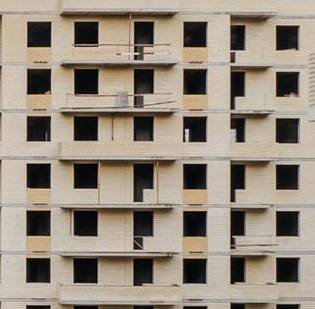

In [235]:
Image.open(path2img)

In [153]:
results = inference_detector(model, image)

### Подготовка gt_detections и pred_detections

Из всех предсказанных детекций, отобрать те которые больше трешхолда.

In [145]:
def select(results: list, threshold: float) -> np.array:
    new_list = []
    for result in results:
        condition = result[:, -1] > threshold
        new_list.append(result[condition])
    return new_list

In [154]:
selected = select(results, threshold = 0.3)

In [155]:
selected

[array([[2.65350433e+02, 6.60167007e+01, 3.07327484e+02, 1.10477875e+02,
         3.88774842e-01],
        [1.42946711e+01, 6.18167114e+01, 5.77031975e+01, 1.07395447e+02,
         3.88591290e-01],
        [1.41583424e+01, 1.54860773e+01, 5.78546143e+01, 6.22842102e+01,
         3.83771390e-01],
        [1.73297318e+02, 1.56837128e+02, 2.15928452e+02, 2.04173141e+02,
         3.79914016e-01],
        [1.71656586e+02, 6.27436562e+01, 2.13981796e+02, 1.10726593e+02,
         3.77604753e-01],
        [1.36353502e+01, 2.50736496e+02, 5.47542191e+01, 2.99055664e+02,
         3.51807088e-01],
        [2.66644012e+02, 2.48223129e+02, 3.09647095e+02, 3.01433228e+02,
         3.41659695e-01],
        [2.66201813e+02, 1.58646484e+02, 3.07757660e+02, 2.01459106e+02,
         3.40227872e-01],
        [2.18044128e+02, 2.50286835e+02, 2.65234955e+02, 2.95817322e+02,
         3.35504770e-01],
        [1.20802628e+02, 2.04726044e+02, 1.63282730e+02, 2.53297073e+02,
         3.33830178e-01],
        [6

Сделать словарь, где по ключу `boxes` будут доступны боксы, а по ключу `brands` название предсказанного класса.

Создадим словарь `id:name_class`, чтобы получить название классов.

In [161]:
id2name_class = {
    0: 'window',
    1: 'empty',
    2: 'filled'
}

In [289]:
def create_dict_from_predict(selected: np.array, id2name_class: dict) -> dict:
    for i, s in enumerate(selected):
        if i == 0:
            concatenated_bbox = s[:, :4]
            concatenated_brands = np.array([id2name_class[i]] * s[:, :4].shape[0])[:, np.newaxis]
        else:
            concatenated_bbox = np.vstack((concatenated_bbox, s[:, :4]))
            brands = np.array([id2name_class[i]] * s[:, :4].shape[0])[:, np.newaxis]
            concatenated_brands = np.vstack((concatenated_brands, brands))
    return {
        'boxes': concatenated_bbox,
        'brands': concatenated_brands.squeeze()
    }

In [290]:
pred_detections = create_dict_from_predict(selected, id2name_class)
pred_detections.keys()

dict_keys(['boxes', 'brands'])

In [291]:
def create_dict_from_gt(example: dict) -> dict:
    return {
        'boxes': example['gt_detections']['boxes'].squeeze().detach().cpu().numpy(),
        'brands': np.array([word[0] for word in example['gt_detections']['brands']])
    }

In [292]:
example = next(iter(dl))
gt_detections = create_dict_from_gt(example)

In [293]:
gt_detections

{'boxes': array([[119.99, 157.52, 167.95, 206.13],
        [ 13.2 ,  12.79,  62.23,  64.88],
        [ 16.8 ,  63.8 ,  62.76, 111.9 ],
        [ 16.8 , 109.76,  62.76, 157.86],
        [ 14.24, 157.26,  61.2 , 204.9 ],
        [ 13.23, 204.48,  61.2 , 253.1 ],
        [ 13.24, 251.49,  61.21, 300.11],
        [ 63.29,  14.  , 111.26,  62.61],
        [ 62.27,  62.01, 110.24, 110.62],
        [ 61.76, 110.02, 109.73, 158.63],
        [ 63.29, 158.54, 111.26, 207.15],
        [ 62.27, 206.04, 110.24, 254.65],
        [ 62.78, 253.03, 110.75, 301.64],
        [118.97,  13.49, 166.93,  62.1 ],
        [119.48,  62.52, 167.44, 111.13],
        [119.48, 110.02, 167.44, 158.63],
        [119.99, 205.02, 167.95, 253.63],
        [119.99, 253.03, 167.95, 301.64],
        [172.08,  11.95, 219.  ,  65.7 ],
        [174.1 ,  62.51, 220.04, 113.7 ],
        [174.09, 110.52, 219.  , 159.7 ],
        [173.61, 157.74, 218.52, 206.93],
        [173.61, 204.73, 218.52, 253.91],
        [172.59, 253.25, 

In [332]:
all_gt = 0
all_correct_pred = 0

for example in dl:
    image = mmcv.imread(example['path2img'][0])
    
    results = inference_detector(model, image)
    selected = select(results, threshold = 0.5)
     
    pred_detections = create_dict_from_predict(selected, id2name_class)
    gt_detections = create_dict_from_gt(example)
    
    errors = count_errors(gt_detections, pred_detections)
    all_gt += errors['n_gt']
    all_correct_pred += errors['n_correctly_class']

accuracy = all_correct_pred / all_gt

accuracy

0.7853658536585366